In [61]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
#from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
DataPath = "../data/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [3]:
print(masks[:10], images[:10])

['TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909_11_mask.tif', 'TCGA_CS_4941_19960909_12_mask.tif', 'TCGA_CS_4941_19960909_13_mask.tif', 'TCGA_CS_4941_19960909_14_mask.tif', 'TCGA_CS_4941_19960909_15_mask.tif', 'TCGA_CS_4941_19960909_16_mask.tif', 'TCGA_CS_4941_19960909_17_mask.tif', 'TCGA_CS_4941_19960909_18_mask.tif', 'TCGA_CS_4941_19960909_19_mask.tif'] ['TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909_12.tif', 'TCGA_CS_4941_19960909_13.tif', 'TCGA_CS_4941_19960909_14.tif', 'TCGA_CS_4941_19960909_15.tif', 'TCGA_CS_4941_19960909_16.tif', 'TCGA_CS_4941_19960909_17.tif', 'TCGA_CS_4941_19960909_18.tif', 'TCGA_CS_4941_19960909_19.tif']


In [4]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [5]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [6]:
imagePath_df.head()

,directory,images,masks
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif


## Config

In [34]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [36]:
# split data into 70% train, 20% validation, and 10% test
train, val = train_test_split(imagePath_df, test_size=0.2, random_state=42)
train, test = train_test_split(imagePath_df, test_size=0.125, random_state=42)
print(f"Train: {train.shape} \nVal: {val.shape} \nTest: {test.shape}")

Train: (3437, 5) 
Val: (786, 5) 
Test: (492, 5)


In [14]:
EPOCHS = 5
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3

In [15]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

## Train

In [40]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)

# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 3437 validated image filenames.
Found 3437 validated image filenames.


In [52]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

# define validation or test
DATA_FRAME = val
# DATA_FRAME = test

# image generator for image/mask
vimage_generator=imagegen.flow_from_dataframe(dataframe=DATA_FRAME,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')

vmask_generator=maskgen.flow_from_dataframe(dataframe=DATA_FRAME,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')   

Found 786 validated image filenames.


Found 786 validated image filenames.


In [53]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [54]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

# Unet


In [55]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [56]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [22]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True).to(device)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [57]:
model.summary()
plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 256, 256, 16)         0         ['batch_normalization_1[0]

# Train

In [24]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [26]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/35


KeyboardInterrupt: 

NameError: name 'results' is not defined

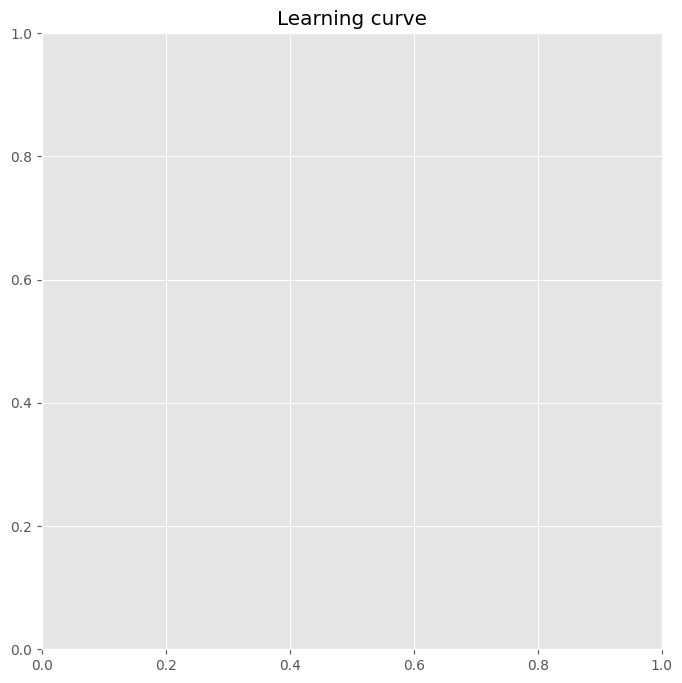

In [30]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()